In [37]:
import math
math.factorial

<function math.factorial(n, /)>

/tmp/ipykernel_67369/2437505631.py:15: RuntimeWarning: overflow encountered in scalar multiply
  norm_factor = (1 / np.sqrt(np.sqrt(np.pi) * 2**n * factorial(n))) * (sigma / np.sqrt(sigma**2 + 0.5))**(0.5)


Relative Frobenius norm error: 0.667163


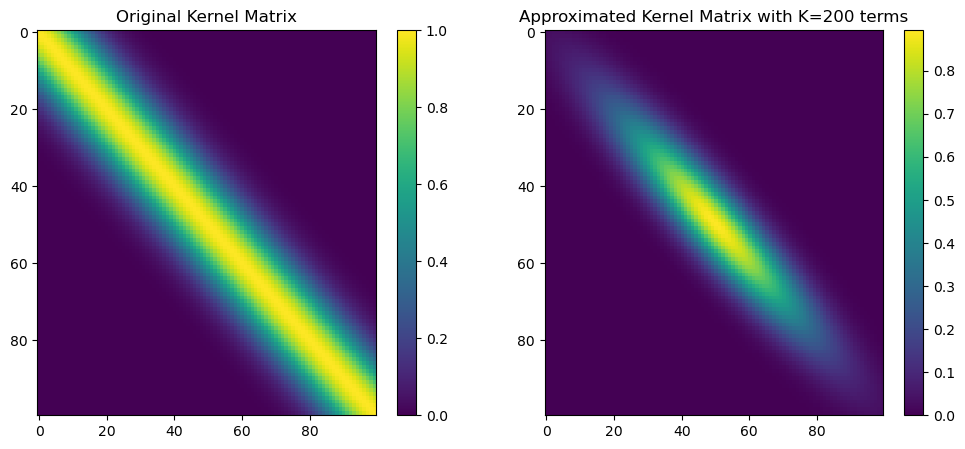

In [64]:
import numpy as np
from scipy.special import eval_hermite, factorial
import matplotlib.pyplot as plt

def compute_eigenvalues(K, sigma):
    n = np.arange(K)
    lambda_n = sigma * np.sqrt(np.pi) * (sigma**2 / (sigma**2 + 0.5))**(n + 0.5)
    return lambda_n

def compute_eigenfunctions(X, K, sigma):
    n_samples = X.shape[0]
    x_scaled = X / np.sqrt(sigma**2 + 0.5)
    phi = np.zeros((n_samples, K))
    for n in range(K):
        norm_factor = (1 / np.sqrt(np.sqrt(np.pi) * 2**n * factorial(n))) * (sigma / np.sqrt(sigma**2 + 0.5))**(0.5)
        Hn_x = eval_hermite(n, x_scaled)
        phi[:, n] = norm_factor * Hn_x * np.exp(- x_scaled**2 / 2)
    return phi

def compute_gaussian_kernel(X, sigma):
    X = X.reshape(-1, 1)
    sq_dists = (X - X.T) ** 2
    K = np.exp(-sq_dists / (2 * sigma**2))
    return K

# Example usage
if __name__ == "__main__":
    # Parameters
    K_terms = 200   # Increase the number of terms
    sigma = 1.0    # Smaller sigma

    # Sample data
    n_samples = 100
    X = np.linspace(-5, 5, n_samples)

    # Compute eigenvalues and eigenfunctions
    eigenvalues = compute_eigenvalues(K_terms, sigma)
    eigenfunctions = compute_eigenfunctions(X, K_terms, sigma)

    # Reconstruct the kernel matrix
    Lambda = np.diag(eigenvalues)
    K_approx = eigenfunctions @ Lambda @ eigenfunctions.T

    # Compute the original Gaussian kernel matrix
    K_original = compute_gaussian_kernel(X, sigma)

    # Compare the matrices
    error = np.linalg.norm(K_original - K_approx) / np.linalg.norm(K_original)
    print(f"Relative Frobenius norm error: {error:.6f}")

    # Visualization
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Kernel Matrix")
    plt.imshow(K_original, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Approximated Kernel Matrix with K={K_terms} terms")
    plt.imshow(K_approx, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.show()


In [79]:
import torch
from torch.distributions import Normal, Uniform
import sys
from pathlib import Path

path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))

from src.kernels import NuclearKernel, GaussianKernel

In [271]:
n = 100
samples = 2000

Z = Uniform(-1,1).sample((n,1))
X = torch.sin(10*Z) + Normal(0,1).sample((n,1))
dist = Normal(torch.zeros(1),torch.ones(1)*X.var()**0.5)
U = dist.sample((samples,))

In [272]:
base_kernel = GaussianKernel(lengthscale = 0.1, 
                                scale = 1.0)
kernel_X = NuclearKernel(base_kernel, 
                        dist,
                        samples)

In [273]:
K_uu = kernel_X.get_gram_base(U,U).detach()
K_xu = kernel_X.get_gram_base(X,U).detach()
K_xx = kernel_X.get_gram_base(X,X).detach()
R_xx = kernel_X.get_gram_approx(X,X).detach()

# Getting eignefunctions and eigenvalues
eigs,vecs = torch.linalg.eig(K_uu/samples)
eigs,vecs = eigs.real.abs(), vecs.real

# Extending to datapoints
Phi_v = samples**-0.5*K_xu @ (vecs / eigs)
Phi_v_tilde = Phi_v @ eigs.diag()**0.5
Phi_v_tilde2 = Phi_v @ eigs.diag()

In [298]:
features = 1000
print((Phi_v_tilde[:,:features] @ Phi_v_tilde.T[:features] - K_xx).abs().mean(),
(Phi_v_tilde2[:,:features] @ Phi_v_tilde2.T[:features] - R_xx).abs().mean())

tensor(8.9770e-07) tensor(0.0004)
